In [ ]:
# Pyresample

[Pyresample](http://github.com/pytroll/pyresample)

[Docs](http://pyresample.readthedocs.org/en/latest/)

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
from pyresample import geometry, kd_tree
import os, gzip
import netCDF4

In [9]:
# Get netcdf data
os.system("wget ftp://osisaf.met.no/reprocessed/ice/conc/v1p1/2008/07/ice_conc_nh_ease-125_reproc_200807011200.nc.gz -O sic.nc.gz")

0

TypeError: Invalid dimensions for image data

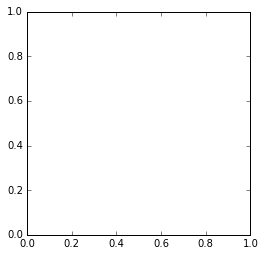

In [36]:
dataset = netCDF4.Dataset('sic.nc')
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
ice_conc = dataset.variables['ice_conc'][:]

ice_conc

swath_def = geometry.SwathDefinition(lons=lons, lats=lats)

In [29]:
# Define area
area_def = geometry.AreaDefinition(
    area_id = 'Istjenesten polar stereographic',
    name = 'istjenesten_stere_north_3k',
    proj_id = 'stere',
    proj_dict = {'a' : '6371228.0',
                 'units' : 'm',
                 'lon_0' : '0',
                 'proj'  : 'stere',
                 'lat_0' : '90',
                 'lat_ts': '90'},
    x_size = 2432,
    y_size = 3584,
    area_extent =(-3850000.0, -5350000.0, 3750000.0, 5850000.0)
    )


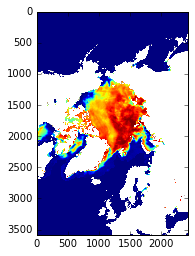

In [35]:
# Resample swath to grid
result = kd_tree.resample_nearest(swath_def,
                                  ice_conc,
                                  area_def,
                                  radius_of_influence=20000)
imshow(result)